In [63]:
from shapely.geometry import Point,mapping, LineString, Polygon
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs

In [64]:
study_area_shapely = Polygon([(275000,77000),(276000,77000),(276000,78000),(275000,78000)])

Haytor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)


network_links = gpd.read_file(os.path.join('Study_area','network_links.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','network_nodes.geojson'))

## OS Detailed Path Network

In [65]:
path_network = gpd.read_file(os.path.join('Detailed-Path-Network', 'DARTMOOR NATIONAL PARK.gml'),layer='RouteLink')

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


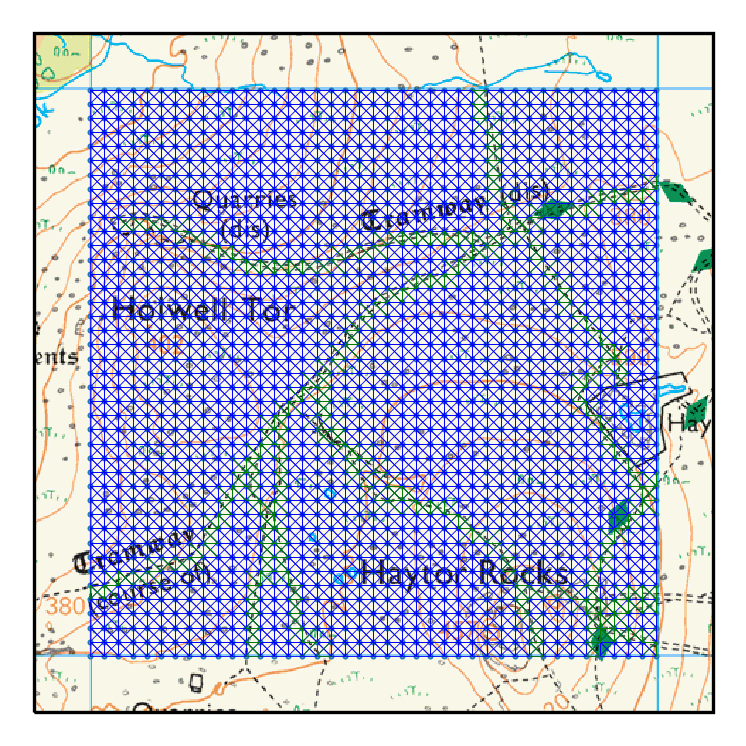

In [66]:
OSDPN= path_network.intersection(study_area_shapely)
OSDPN= OSDPN[~OSDPN.is_empty]
OSDPN_gpd = gpd.GeoDataFrame(geometry=OSDPN)

Intersecting_nodes = gpd.sjoin(network_nodes,OSDPN_gpd)
Intersecting_links = gpd.sjoin(network_links,OSDPN_gpd)

back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# displaying nodes
network_nodes.plot(ax=ax,zorder = 2,markersize=0.2)
#displaying links
network_links.plot(ax=ax,zorder = 2,edgecolor='blue', linewidth=0.2)


# intersecting
Intersecting_nodes.plot(ax=ax,zorder=3,markersize=0.2,color='green')
Intersecting_links.plot(ax=ax,zorder=3,edgecolor='green', linewidth=0.2)
#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

In [67]:
Intersecting_links = Intersecting_links.drop('index_right',1)
Intersecting_links['DPN'] = 1
DPN = Intersecting_links["DPN"]
network_links_DPN = network_links.join(DPN)
network_links_DPN["DPN"] = network_links_DPN["DPN"].fillna(2)

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


## Open Street Map

In [68]:
road_links = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_roads_Dartmoor_link.geojson'))
road_links = road_links.to_crs(27700)
path_links = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_track_Dartmoor_link.geojson'))
path_links = path_links.to_crs(27700)

In [69]:
path_geom_links = [path for path in path_links['geometry']]
road_geom_links = [road for road in road_links['geometry']]
all_geom = path_geom_links + road_geom_links

path_ids_links = [id for id in path_links['full_id']]
road_ids_links = [id for id in road_links['full_id']]
ids = path_ids_links + road_ids_links

Dartmoor_links = gpd.GeoDataFrame({'fid': ids, 'geometry':all_geom})

#removing duplicates
G = Dartmoor_links.geometry.apply(lambda geom: geom.wkb)
Dartmoor_links = Dartmoor_links.loc[G.drop_duplicates().index]

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  """
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.1

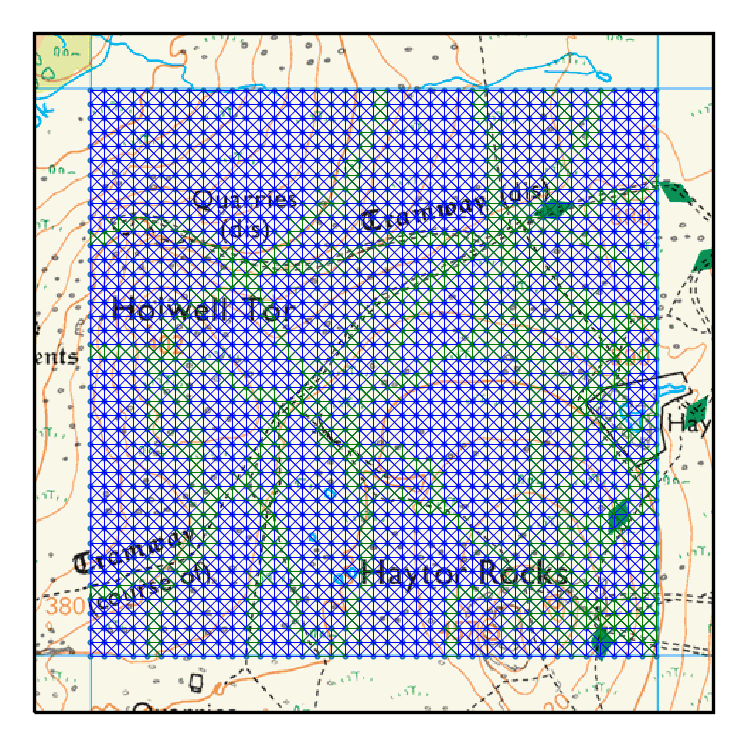

In [70]:
OSM_paths = Dartmoor_links.intersection(study_area_shapely)
OSM_paths = OSM_paths[~OSM_paths.is_empty]
OSM_paths_gpd = gpd.GeoDataFrame(geometry=OSM_paths)

Intersecting_nodes = gpd.sjoin(network_nodes,OSM_paths_gpd)
Intersecting_links = gpd.sjoin(network_links_DPN,OSM_paths_gpd)

back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# displaying nodes
network_nodes.plot(ax=ax,zorder = 2,markersize=0.2)
#displaying links
network_links.plot(ax=ax,zorder = 2,edgecolor='blue', linewidth=0.2)


# intersecting
Intersecting_nodes.plot(ax=ax,zorder=3,markersize=0.2,color='green')
Intersecting_links.plot(ax=ax,zorder=3,edgecolor='green', linewidth=0.2)
#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

In [71]:
Intersecting_links = Intersecting_links.drop('index_right',1)
Intersecting_links['OSM'] = 1
OSM = Intersecting_links['OSM']
network_links_OSM = network_links_DPN.join(OSM)
network_links_OSM['OSM'] = network_links_OSM['OSM'].fillna(2)

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Adding column for climb_time

In [73]:
total_time= []
for index,row in network_links_OSM.iterrows():
    length_time = row.length / (500 / 6)
    total_time.append(length_time + row.climb_time_forward)

network_links_OSM['total_time'] = total_time

## Normalising DPN,OSM and total_time

In [79]:
network_links_OSM['DPN_Normalised'] = network_links_OSM['DPN'].div(network_links_OSM['DPN'].sum())
network_links_OSM['OSM_Normalised'] = network_links_OSM['OSM'].div(network_links_OSM['OSM'].sum())
network_links_OSM['total_time_Normalised'] = network_links_OSM['total_time'].div(network_links_OSM['total_time'].sum())

## Add weights

In [93]:
weights = [0.9,0.05,0.05]
graph = nx.DiGraph()
for index,row in network_links_OSM.iterrows():

    dpn = (row.DPN_Normalised * weights[0])*100000
    osm = (row.OSM_Normalised * weights[1])*100000
    travel_time = (row.total_time_Normalised * weights[2])*100000
    # Weighted Sum method
    wsm = dpn + osm + travel_time

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=row.length,
               weighted_sum=wsm)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source=1, target=1665, weight='weighted_sum')

geom = []
links = []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

weighted_path_forward_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


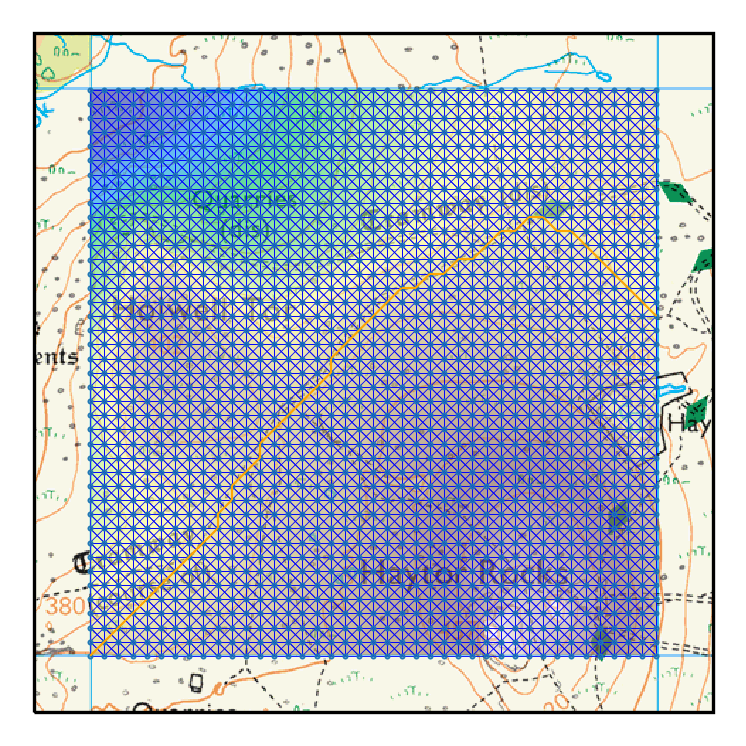

In [94]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                           cmap='terrain')

# displaying nodes
network_nodes.plot(ax=ax,zorder = 3,markersize=0.2)

#displaying links
network_links.plot(ax=ax,zorder = 2,edgecolor='blue', linewidth=0.2)

# display path
weighted_path_forward_gpd.plot(ax=ax,zorder = 5,edgecolor='orange', linewidth=0.5)
# time_weighted_path_backward_gpd.plot(ax=ax,zorder = 5,edgecolor='green', linewidth=0.5)


#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()